# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

En este proyecto el proposito principal es determinar cual plan es mas elegible para poder usar mas presupuesto en el. Se van a tomar en cuenta algunos factores como es el ingreso, ciudad, etc.

## Inicialización

Primero vamos a cargar las librerias que puedan ser utiles.

In [91]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import seaborn as sns
from scipy import stats as st

## Cargar los datos

Luego vamos a cargar los diferentes csv en dataframes.

In [92]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv('datasets/megaline_calls.csv')
internet = pd.read_csv('datasets/megaline_internet.csv')
messages = pd.read_csv('datasets/megaline_messages.csv')
plans = pd.read_csv('datasets/megaline_plans.csv')
users = pd.read_csv('datasets/megaline_users.csv')

## Preparar los datos

Dado a que hay algunos dataframes vamos a analizar detalladamente cada uno y sus contenidos para ver si se puede corregir ciertos datos o enriquecerlos.

Iremos en el siguiente orden: Planes, Usuarios, Llamadas, Mensajes, Internet. Para cada uno imprimiremos su informacion y luego una muestra del dataframe.

## Planes

In [93]:
# Imprime la información general/resumen sobre el DataFrame de los planes
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [94]:
# Imprime una muestra de los datos para los planes
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Corregir los datos

No se ven datos que puedan necesitar una correccion, por lo que se dejara los datos tal cual estaban.

## Enriquecer los datos

Se pueden cambiar los datos, pues vamos a hacer el analisis en torno a gigabytes, no megabytes (1 gigabyte es equivalente a 1000 megabytes). Luego cambiaremos el nombre de la columna de "mb_included" a "gb_per_month_included".

In [95]:
plans = plans.rename({'mb_per_month_included':'gb_per_month_included'}, axis=1)
plans['gb_per_month_included'] = plans['gb_per_month_included'] / 1024
plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate




<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Recuerda que la conversión de megabytes a gigabytes equilate a 1024, en vez de 1000. Esta suposición podría afectarte un poco por lo tanto intenta considerar el factor de conversión sugerido. Además, considera redondear hacia arriba en los casos que sea necesario.
    
</div>


## Usuarios

In [96]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [97]:
# Imprime una muestra de los datos para los usuarios
users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


Se puede ver que el dataframe de por si es corto, es decir, no hay muchos usuarios pero puede que cada uno tenga bastantes usos mensualmente, por lo que se puede esperar una cifra mas alta en los siguientes dataframes.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a><br>
Recuerda verificar la existencia de datos duplicados y establece una estrategía o plan de acción cuando nos encontremos con datos faltentes. Como en el caso de churn_date.
</div>


### Corregir datos

Vamos a comenzar cambiando el tipo de datos en las columnas "reg_date" y "churn_date" a tipo datetime.

In [98]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format= '%Y-%m-%d')



<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a><br>
Correcto
</div>


### Enriquecer datos

Luego podremos extraer el mes de la fecha de los usuarios, pues puede ser relevante al siguiente estudio.

In [99]:
users['month'] = users['reg_date'].dt.month

## Llamadas

In [100]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [101]:
# Imprime una muestra de datos para llamadas
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [102]:
calls = calls.drop(calls[calls.duration == 0].index)

Como se esperaba, las llamadas son un numero superior al de usuarios, por lo que se espera que cada uno tenga varios usos, asi mismo como puede que uno no tenga llamadas pero otro tenga 1000 llamadas.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Recuerda utilizar el método .describe() para examinar los valores de nuestras columnas. En este caso tenemos una gran cantidad de llamadas con duración 0. 
</div>


### Corregir datos

Vamos a corregir el "call_date" cambiandolo a tipo datetime. Luego vamos a hacer la columna "duration" a tipo "int64".

In [103]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = (np.ceil(calls['duration'])).astype('int64')



<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Correcto. De acuerdo a la descripción del plan hacemos un round up a la duración.
    
</div>


### Enriquecer datos

De nuevo extraemos el mes de las llamadas.

In [104]:
calls['month'] = calls['call_date'].dt.month



<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Correcto. Necesitamos extraer el mes.
    
</div>


## Mensajes

In [105]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [106]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


Se ven mensajes, que en su totalidad son superiores al numero de usuarios tambien. 

### Corregir datos

Vamos a cambiar la columna "message_date" a tipo datetime.

In [107]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Enriquecer datos

De nuevo extraemos el mes de la fecha del mensaje.

In [108]:
messages['month'] = messages['message_date'].dt.month

## Internet

In [109]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [110]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Se puede ver el problema comun: las fechas no estan en datetime.

### Corregir datos

Vamos a pasar el "session_date" a datetime y vamos a pasar los "mb_used" a gb, es decir, dividir para 1000.

In [111]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet = internet.rename({'mb_used': 'gb_used'}, axis= 1)
internet['gb_used'] = np.ceil(internet['gb_used'] / 1024)
internet

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,1.0
1,1000_204,1000,2018-12-31,0.0
2,1000_379,1000,2018-12-28,1.0
3,1000_413,1000,2018-12-26,1.0
4,1000_442,1000,2018-12-27,1.0
...,...,...,...,...
104820,1499_215,1499,2018-10-20,1.0
104821,1499_216,1499,2018-12-30,1.0
104822,1499_217,1499,2018-09-22,1.0
104823,1499_218,1499,2018-12-07,0.0




<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Considera redondear la variable gb_used. Para tener una mejor presentación de datos.
    
</div>


### Enriquecer datos

Vamos a extraer el mes del session_date.

In [112]:
internet['month'] = internet['session_date'].dt.month



<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
No olvides utilizar los métodos de exploración `info`, `head`, y `describe` siempre que nos encontremos con un dataset nuevo. Así mismo, recuerda terminar siempre con un resumen de tus conclusiones al final de la fase de exploración. 
</div>


## Estudiar las condiciones del plan

Vamos a repasar las condiciones del plan para recordar especificamente lo que se especifica.

In [113]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Vamos a agregar los datos por mes en cuanto a llamadas, minutos usados ("duration"), mensajes ("message_count"), e internet ("gb_used"). Luego vamos a aplicar el metodo merge a los 3 dataframes con los usuarios y planes, enfocandonos en el mes y "user_id".

In [125]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls_by_id = calls.groupby(['user_id', 'month'])[['id']].count().reset_index()
calls_by_id = calls_by_id.rename({'id':'call_count'}, axis=1)
calls_by_id

# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
minutes_used = calls.groupby(['user_id', 'month'])[['duration']].sum().reset_index()
minutes_used

# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages_by_user_id = messages.groupby(['user_id', 'month'])[['id']].count().reset_index()
messages_by_user_id = messages_by_user_id.rename({'id':'message_count'}, axis=1)
messages_by_user_id

# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
internet_by_user_id = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
internet_by_user_id
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
new_df = internet_by_user_id.merge(calls_by_id, on=['user_id', 'month'], how='outer').merge(minutes_used, on=['user_id', 'month'], how='outer').merge(messages_by_user_id, on=['user_id', 'month'], how='outer')
new_df

,user_id,month,gb_used,call_count,duration,message_count
0,1000,12,4.0,16.0,124.0,11.0
1,1001,8,21.0,22.0,182.0,30.0
2,1001,9,41.0,38.0,315.0,44.0
3,1001,10,50.0,47.0,393.0,53.0
4,1001,11,49.0,49.0,426.0,36.0
...,...,...,...,...,...,...
2288,1470,11,NaN,63.0,632.0,156.0
2289,1470,12,NaN,64.0,592.0,153.0
2290,1484,11,NaN,2.0,38.0,1.0
2291,1491,4,NaN,6.0,44.0,6.0


In [115]:
pivot_calls = calls.pivot_table(index=['user_id', 'month'],
    values=['duration'],
    aggfunc=['sum','count']).reset_index()

pivot_msg = messages.pivot_table(index=['user_id', 'month'],
    values=['id'],
    aggfunc='count').reset_index()

pivot_internet = internet.pivot_table(index=['user_id', 'month'],
    values=['gb_used'],
    aggfunc='sum').reset_index()

In [116]:
pivot_calls

,user_id,month,sum,count
,,,duration,duration
0,1000,12,124,16
1,1001,8,182,22
2,1001,9,315,38
3,1001,10,393,47
4,1001,11,426,49
...,...,...,...,...
2251,1498,12,339,32
2252,1499,9,346,35
2253,1499,10,385,41




<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a><br>
Correcto
    
</div>


In [117]:
pivot_calls

,user_id,month,sum,count
,,,duration,duration
0,1000,12,124,16
1,1001,8,182,22
2,1001,9,315,38
3,1001,10,393,47
4,1001,11,426,49
...,...,...,...,...
2251,1498,12,339,32
2252,1499,9,346,35
2253,1499,10,385,41


In [119]:
# Flatten the column index of pivot_calls
pivot_calls.columns = ['user_id', 'month', 'calls_duration_sum', 'calls_duration_count']

# Flatten the column index of pivot_msg
pivot_msg.columns = ['user_id', 'month', 'messages_count']

# Flatten the column index of pivot_internet
pivot_internet.columns = ['user_id', 'month', 'internet_gb_used']

# Merge the pivot tables using an outer join
all_data = pd.merge(pivot_calls, pivot_msg, on=['user_id', 'month'], how='outer')
all_data = pd.merge(all_data, pivot_internet, on=['user_id', 'month'], how='outer')

In [120]:
all_data

,user_id,month,calls_duration_sum,calls_duration_count,messages_count,internet_gb_used
0,1000,12,124.0,16.0,11.0,4.0
1,1001,8,182.0,22.0,30.0,21.0
2,1001,9,315.0,38.0,44.0,41.0
3,1001,10,393.0,47.0,53.0,50.0
4,1001,11,426.0,49.0,36.0,49.0
...,...,...,...,...,...,...
2288,1407,11,NaN,NaN,1.0,1.0
2289,1482,10,NaN,NaN,2.0,NaN
2290,1094,10,NaN,NaN,NaN,3.0
2291,1108,12,NaN,NaN,NaN,2.0


In [122]:
users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,5
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT,9
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT,2
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT,12
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT,2


In [126]:
# Añade la información del plan
new_df2 = new_df.merge(users, on=['user_id'], how='left').drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date'], axis=1)
new_df2 = new_df2.merge(plans, left_on='plan', right_on='plan_name', how='left').drop(['month_y'], axis=1)
new_df2 = new_df2.rename({'month_x':'month'}, axis=1)
new_df2['call_count'] = new_df2['call_count'].fillna(0)
new_df2['duration'] = new_df2['duration'].fillna(0)
new_df2['message_count'] = new_df2['message_count'].fillna(0)
print(new_df2.info())
new_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   int64  
 2   gb_used                2277 non-null   float64
 3   call_count             2293 non-null   float64
 4   duration               2293 non-null   float64
 5   message_count          2293 non-null   float64
 6   city                   2293 non-null   object 
 7   plan                   2293 non-null   object 
 8   messages_included      2293 non-null   int64  
 9   gb_per_month_included  2293 non-null   float64
 10  minutes_included       2293 non-null   int64  
 11  usd_monthly_pay        2293 non-null   int64  
 12  usd_per_gb             2293 non-null   int64  
 13  usd_per_message        2293 non-null   float64
 14  usd_per_minute         2293 non-null   float64
 15  plan

,user_id,month,gb_used,call_count,duration,message_count
0,1000,12,4.0,16.0,124.0,11.0
1,1001,8,21.0,22.0,182.0,30.0
2,1001,9,41.0,38.0,315.0,44.0
3,1001,10,50.0,47.0,393.0,53.0
4,1001,11,49.0,49.0,426.0,36.0
...,...,...,...,...,...,...
2288,1470,11,NaN,63.0,632.0,156.0
2289,1470,12,NaN,64.0,592.0,153.0
2290,1484,11,NaN,2.0,38.0,1.0
2291,1491,4,NaN,6.0,44.0,6.0


Ahora vamos a sacar los ingresos mensuales, sacando lo que cada usuario paga por el plan y sumandole los gastos extras dependiendo si han usado extra mensajes, llamadas, gb, etc. Para esto vmaos a usar funciones. Sabiendo que cada 1023 mb (1.023gb) que se pasen del limite del paquete te cobran 1gb ($7), se divide para 1.023 y multiplicar por el cobro por gb. Este es el unico caso que es diferente a los demas, pues se cobra de una manera especifica. El resto se puede usar con los cobros del mismo dataframe, es decir, usando las variables de el mismo.

In [127]:
# Calcula el ingreso mensual para cada usuario

def extra_gb(row):
    gb = row['gb_used']
    plan = row['plan']
    gb_max = row['gb_per_month_included']
    usd_per_gb = row['usd_per_gb']
    if plan == 'surf':
        if gb > gb_max:
            return np.ceil(((gb - gb_max)/ 1.023)) * usd_per_gb
        else:
            return 0
    if plan == 'ultimate':
        if gb > gb_max:
            return np.ceil(((gb - gb_max)/ 1.023 )) * usd_per_gb
        else:
            return 0
        
def extra_messages(row):
    msg = row['message_count']
    plan = row['plan']
    msg_max = row['messages_included']
    usd_per_msg = row['usd_per_message']
    if plan == 'surf':
        if msg > msg_max:
            return ((msg - msg_max) * usd_per_msg)
        else:
            return 0
    if plan == 'ultimate':
        if msg > msg_max:
            return ((msg - msg_max) * usd_per_msg)
        else:
            return 0

def extra_minutes(row):
    duration = row['duration']
    plan = row['plan']
    min_max = row['minutes_included']
    usd_per_min = row['usd_per_minute']
    if plan == 'surf':
        if duration > min_max:
            return ((duration - min_max) * usd_per_min)
        else:
            return 0
    if plan == 'ultimate':
        if duration > min_max:
            return ((duration - min_max) * usd_per_min)
        else:
            return 0
        
print(extra_gb(new_df2.loc[0]))
print(extra_gb(new_df2.loc[3]))

print(extra_messages(new_df2.loc[3]))
print(extra_messages(new_df2.loc[0]))

print(extra_minutes(new_df2.loc[9]))
print(extra_minutes(new_df2.loc[24]))

new_df2['extra_usd_minutes'] = new_df2.apply(extra_minutes, axis=1)
new_df2['extra_usd_messages'] = new_df2.apply(extra_messages, axis=1)
new_df2['extra_usd_gb'] = new_df2.apply(extra_gb, axis=1)
new_df2['total_extra_usd'] = (new_df2['extra_usd_minutes'] + new_df2['extra_usd_messages'] + new_df2['extra_usd_gb'])
new_df2['total_paid'] = (new_df2['usd_monthly_pay'] + new_df2['total_extra_usd'])

new_df2

0
350.0
0.09
0
18.12
0.72


,user_id,month,gb_used,call_count,duration,message_count,city,plan,messages_included,gb_per_month_included,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,extra_usd_minutes,extra_usd_messages,extra_usd_gb,total_extra_usd,total_paid
0,1000,12,4.0,16.0,124.0,11.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,30.0,...,70,7,0.01,0.01,ultimate,0.00,0.00,0.0,0.00,70.00
1,1001,8,21.0,22.0,182.0,30.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.00,60.0,60.00,80.00
2,1001,9,41.0,38.0,315.0,44.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.00,260.0,260.00,280.00
3,1001,10,50.0,47.0,393.0,53.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.09,350.0,350.09,370.09
4,1001,11,49.0,49.0,426.0,36.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.00,340.0,340.00,360.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,11,NaN,63.0,632.0,156.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,3.96,3.18,0.0,7.14,27.14
2289,1470,12,NaN,64.0,592.0,153.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,2.76,3.09,0.0,5.85,25.85
2290,1484,11,NaN,2.0,38.0,1.0,"Dallas-Fort Worth-Arlington, TX MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.00,0.0,0.00,20.00
2291,1491,4,NaN,6.0,44.0,6.0,"Grand Rapids-Kentwood, MI MSA",surf,50,15.0,...,20,10,0.03,0.03,surf,0.00,0.00,0.0,0.00,20.00


## Estudia el comportamiento del usuario

Ahora vamos a estudiar los parametros mediante histogramas, diagramas de caja, varianzas y promedios. Vamos a agruparlos a todos por plan y mes, dependiendo de los parametros. Primero lo haremos para las llamadas. Vamos a buscar la duracion promedio de llamadas por cada plan por cada mes. Para esto se puede hacer un groupby del new_df2, agrupando el mes y plan como previamente habiamos mencionado, sacando la informacion de la columna "duration". Luego haremos un reset_index() para no tener un multi-index. Luego usaremos los axes de matplotlib para poder hacer los histogramas, dependiendo del mes y duracion para cada uno de los planes. Especificaremos las etiquetas, ejes y leyendas.

Luego haremos algo similar pero con la totalidad de uso de minutos por mes dependiendo del plan, es decir, ver cuanto es lo que necesitan. Al terminar de agrupar la suma, haremos un bucle para los planes, y usaremos asi mismo los axes de matplotlib, pero en este caso la funcion .hist(), usando .loc[], para localizar el plan y la duracion, asi mismo como establecer la etiqueta del plan.

Seguiremos calculando la media de "duration" por mes, usando el groupby(). Hacemos lo mismo luego con la varianza. 

Para finalizar haremos un query del new_df2 para separarlo por planes, es decir uno surf y otro ultimate. Usaremos la funcion de .boxplot() ya que es la pertinente para los dataframes y pasaremos como argumentos column='duration' y by='month' (ya que queremos ver la distribucion de las duracion por mes).

Este proceso luego se repite para diferentes usos, es decir, se hace el mismo codigo pero cambiando dependiendo de lo que quermeos buscar (internet, mensajes, ingresos).


### Llamadas

In [128]:
plt.rcParams['axes.facecolor'] = 'navajowhite'

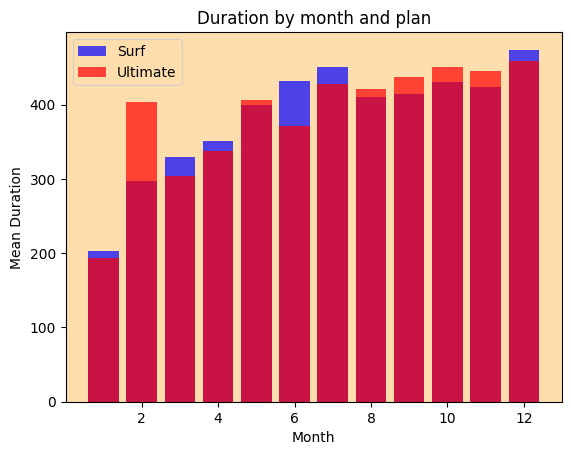

In [129]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
min_mon_plan= new_df2.groupby(['month', 'plan'])['duration'].mean().reset_index()

fig, ax = plt.subplots()

surf_calls1= min_mon_plan.query('plan == "surf"')
ax.bar(surf_calls1['month'], surf_calls1['duration'], label='Surf', alpha=0.7, color='b')

ult_calls1= min_mon_plan.query('plan == "ultimate"')
ax.bar(ult_calls1['month'], ult_calls1['duration'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Mean Duration')
ax.set_title('Duration by month and plan')

ax.legend()

plt.show()

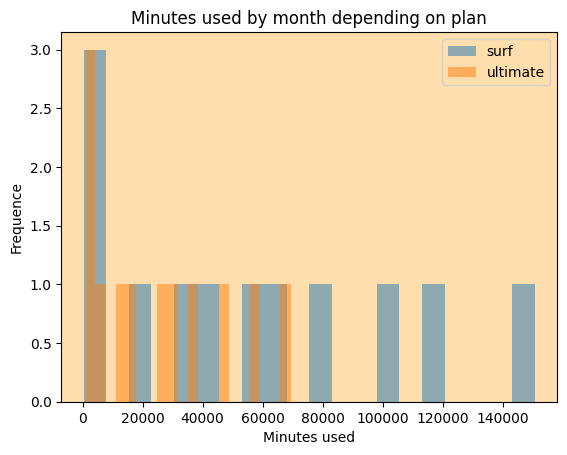

In [130]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.
relative_data = new_df2[['plan', 'month', 'duration']]

total_minutes = relative_data.groupby(['plan', 'month']).sum()

fig, ax = plt.subplots()

for plan in ['surf', 'ultimate']:
    ax.hist(total_minutes.loc[plan, 'duration'], alpha=0.5, label=plan, bins=20)

ax.legend()
ax.set_xlabel('Minutes used')
ax.set_ylabel('Frequence')
ax.set_title('Minutes used by month depending on plan')

plt.show()

In [131]:
# Calcula la media y la varianza de la duración mensual de llamadas.
duration_mean = new_df2.groupby('month')['duration'].mean()
duration_var = new_df2.groupby('month')['duration'].var()
print(duration_mean)
print(duration_var)

month
1     196.666667
2     343.437500
3     321.171429
4     347.197183
5     401.405660
6     411.604167
7     442.472222
8     413.562232
9     421.378571
10    436.221574
11    430.100000
12    469.091684
Name: duration, dtype: float64
month
1     13135.866667
2     61567.329167
3     43378.499160
4     45620.531992
5     54950.510063
6     45086.240822
7     64525.781347
8     53926.747188
9     49735.899181
10    52829.190527
11    54351.738142
12    63180.258670
Name: duration, dtype: float64


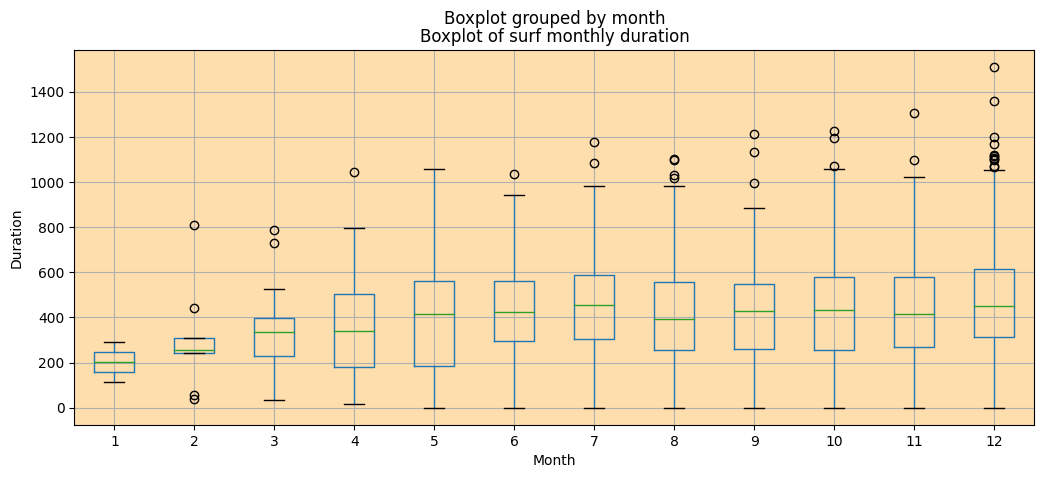

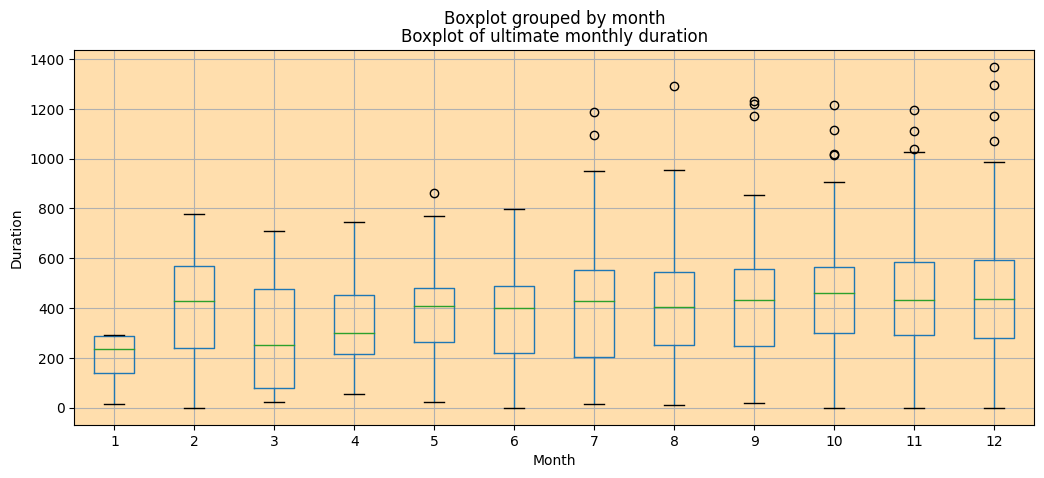

In [132]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
surf = new_df2.query('plan == "surf"')
ultimate= new_df2.query('plan == "ultimate"')

surf_bplot = surf.boxplot(column='duration', by='month', figsize=(12,5))
plt.ylabel('Duration')
plt.xlabel('Month')
plt.title('Boxplot of surf monthly duration')
plt.show()
ultimate_bplot = ultimate.boxplot(column='duration', by='month', figsize=(12,5))
plt.ylabel('Duration')
plt.xlabel('Month')
plt.title('Boxplot of ultimate monthly duration')
plt.show()

Podemos notar que el plan surf tiene mayor movimiento en cuanto a duracion de llamadas, aun siendo el que menos incluye dentro del paquete. El mes en el que mas se mueve siendo diciembre.

### Mensajes

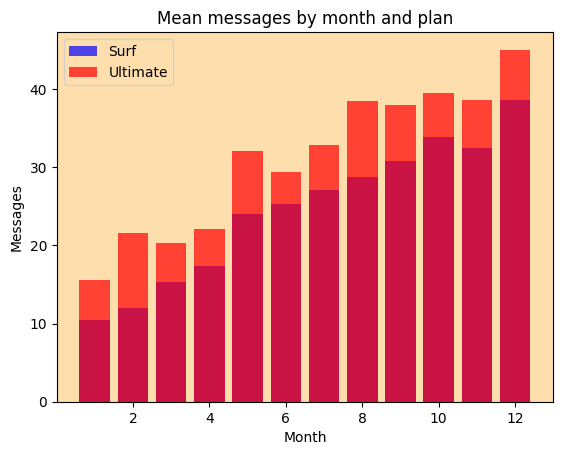

In [133]:
message_count_mean_by_plan= new_df2.groupby(['month', 'plan'])['message_count'].mean().reset_index()

fig, ax = plt.subplots()

surf_messages1= message_count_mean_by_plan.query('plan == "surf"')
ax.bar(surf_messages1['month'], surf_messages1['message_count'], label='Surf', alpha=0.7, color='b')

ult_messages1= message_count_mean_by_plan.query('plan == "ultimate"')
ax.bar(ult_messages1['month'], ult_messages1['message_count'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Messages')
ax.set_title('Mean messages by month and plan')

ax.legend()

plt.show()

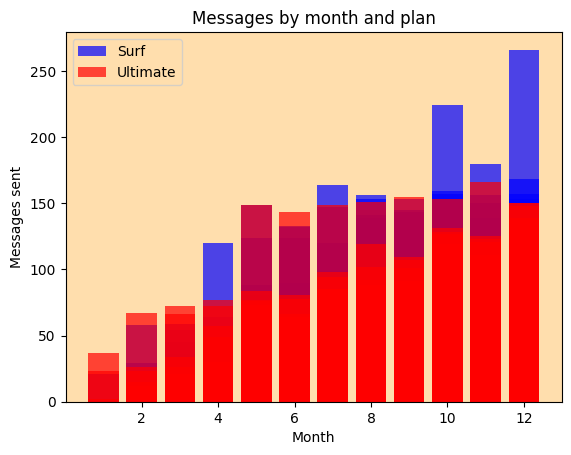

In [134]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
message_month_plan = new_df2[['month', 'plan', 'message_count']]

total_messages = message_month_plan.groupby(['plan', 'month']).sum()

fig, ax = plt.subplots()

surf_message2= message_month_plan.query('plan == "surf"')
ax.bar(surf_message2['month'], surf_message2['message_count'], label='Surf', alpha=0.7, color='b')

ult_message2= message_month_plan.query('plan == "ultimate"')
ax.bar(ult_message2['month'], ult_message2['message_count'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Messages sent')
ax.set_title('Messages by month and plan')

ax.legend()

plt.show()

In [135]:
message_count_mean = new_df2.groupby('month')['message_count'].mean()
message_count_var = new_df2.groupby('month')['message_count'].var()
print(message_count_mean)
print(message_count_var)

month
1     13.833333
2     16.187500
3     16.971429
4     18.774648
5     26.226415
6     26.618056
7     28.933333
8     31.733906
9     32.953571
10    35.571429
11    34.312195
12    40.663113
Name: message_count, dtype: float64
month
1      238.966667
2      421.229167
3      441.734454
4      511.148491
5      972.291105
6      893.706245
7      938.051397
8     1095.446130
9     1025.442281
10    1261.771930
11    1122.582003
12    1493.270880
Name: message_count, dtype: float64


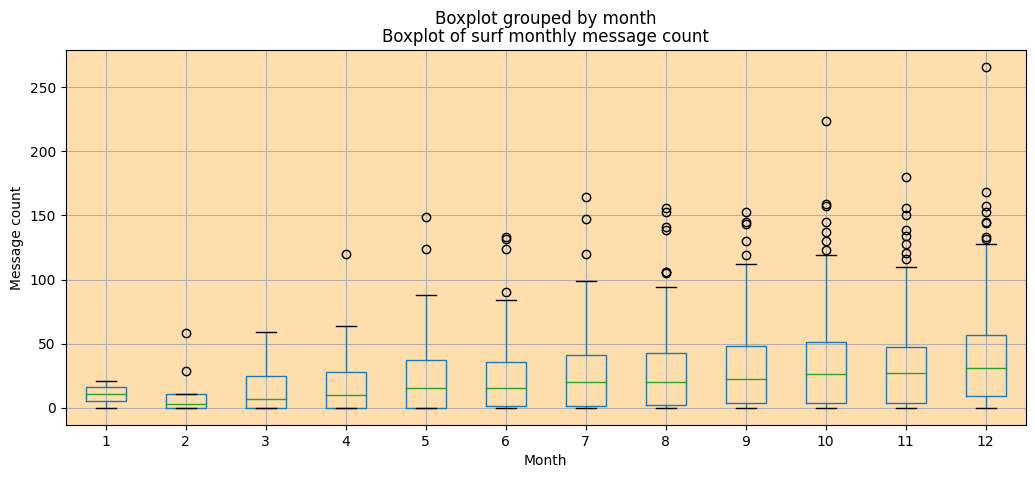

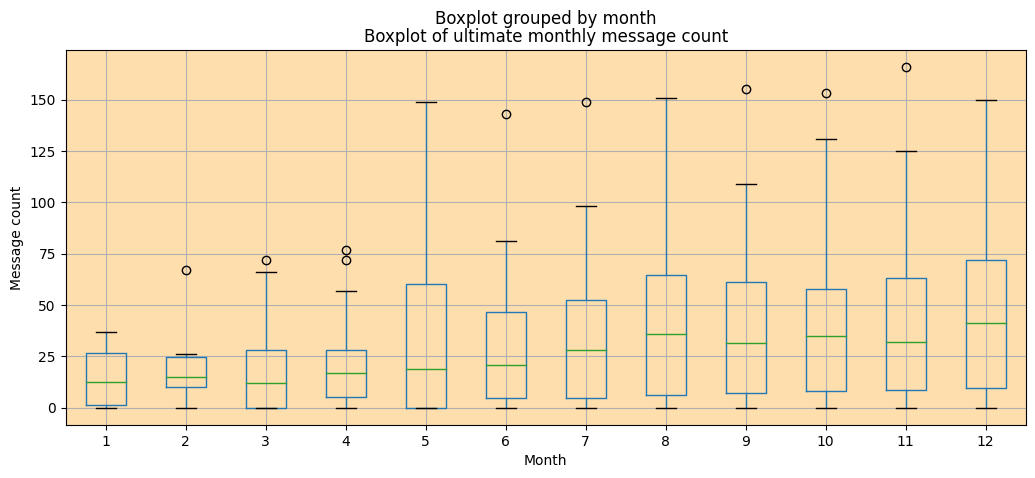

In [136]:
surf_bplot_messages = surf.boxplot(column='message_count', by='month', figsize=(12,5))
plt.ylabel('Message count')
plt.xlabel('Month')
plt.title('Boxplot of surf monthly message count')
plt.show()
ultimate_bplot_messages = ultimate.boxplot(column='message_count', by='month', figsize=(12,5))
plt.ylabel('Message count')
plt.xlabel('Month')
plt.title('Boxplot of ultimate monthly message count')
plt.show()

Se puede notar de nuevo que el movimiento de los usuarios del plan surf en cuanto a mensajes es mayor, es decir, mandan mas mensajes. Nuevamente el mes mas concurrido es diciembre.

### Internet

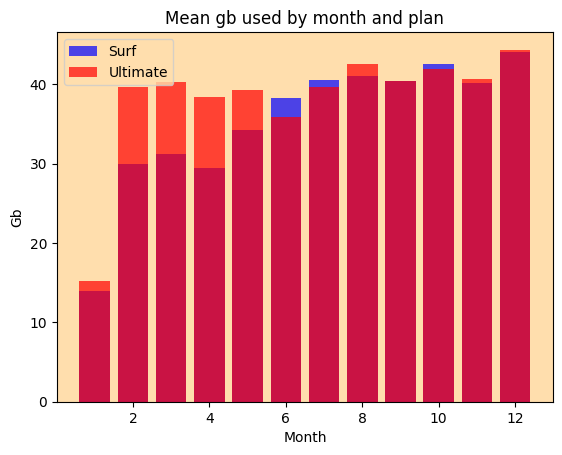

In [137]:
gb_used_mean_by_plan= new_df2.groupby(['month', 'plan'])['gb_used'].mean().reset_index()

fig, ax = plt.subplots()

surf_gb1= gb_used_mean_by_plan.query('plan == "surf"')
ax.bar(surf_gb1['month'], surf_gb1['gb_used'], label='Surf', alpha=0.7, color='b')

ult_gb1= gb_used_mean_by_plan.query('plan == "ultimate"')
ax.bar(ult_gb1['month'], ult_gb1['gb_used'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Gb')
ax.set_title('Mean gb used by month and plan')

ax.legend()

plt.show()

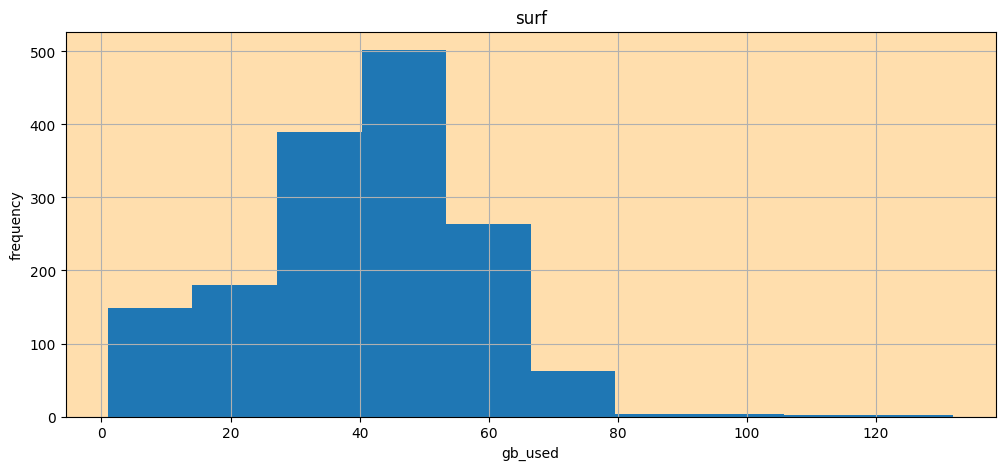

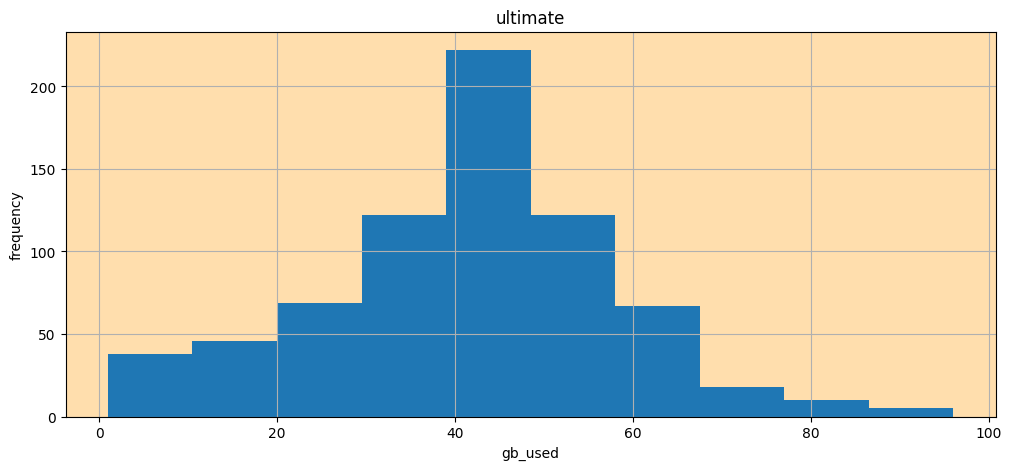

In [139]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
for plan, data in new_df2.groupby('plan'):
    data.hist('gb_used', grid=True, figsize=(12,5))
    plt.title(plan)
    plt.ylabel('frequency')
    plt.xlabel('gb_used')



<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Revisa los valores para esta variable. Se está sobreestimando algunos datos para el cálculo.
    
</div>


In [140]:
gb_used_mean = new_df2.groupby('month')['gb_used'].mean()
gb_used_var = new_df2.groupby('month')['gb_used'].var()
print(gb_used_mean)
print(gb_used_var)

month
1     14.833333
2     34.250000
3     34.342857
4     32.157143
5     35.676190
6     37.492958
7     40.284916
8     41.526087
9     40.440860
10    42.348083
11    40.394608
12    44.181624
Name: gb_used, dtype: float64
month
1      61.366667
2     297.000000
3     456.467227
4     353.931470
5     291.682601
6     248.719808
7     303.620614
8     315.481849
9     235.556742
10    261.771971
11    270.981494
12    317.211053
Name: gb_used, dtype: float64


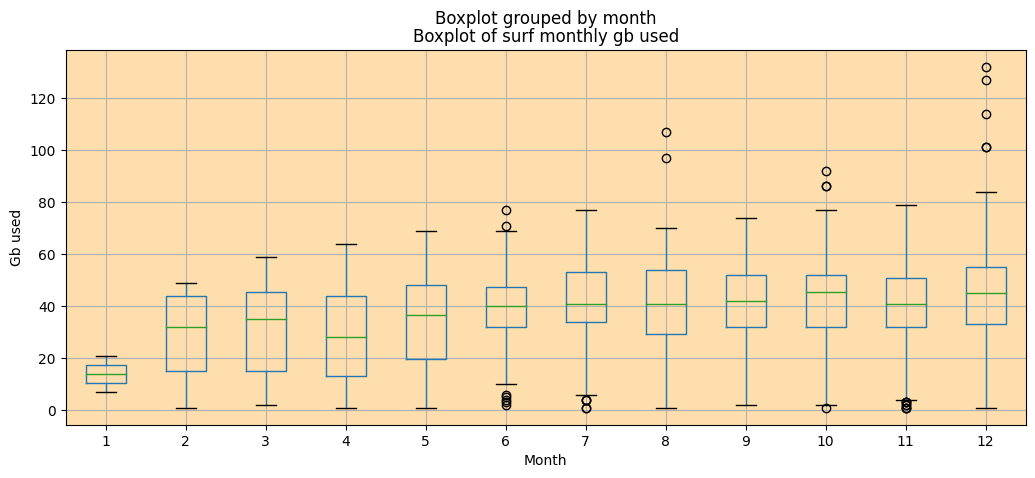

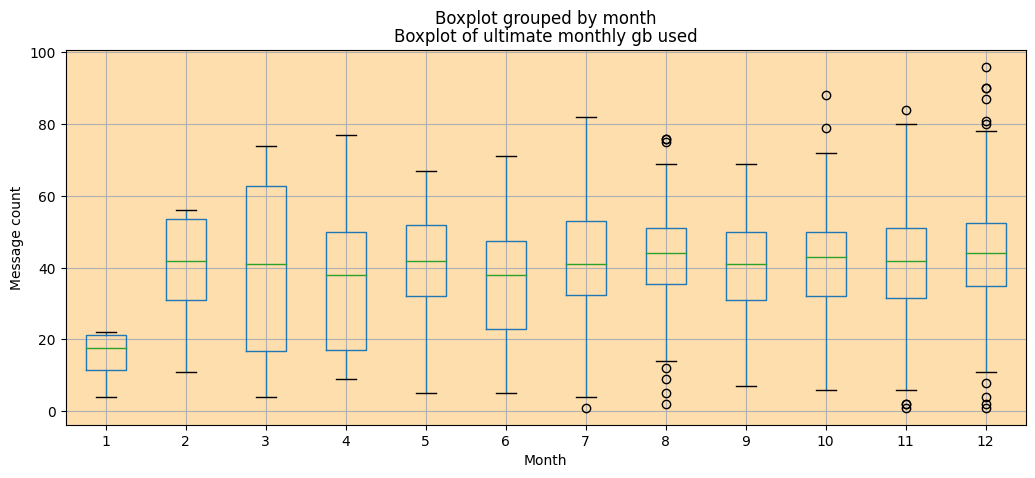

In [141]:
surf_bplot_messages = surf.boxplot(column='gb_used', by='month', figsize=(12,5))
plt.ylabel('Gb used')
plt.xlabel('Month')
plt.title('Boxplot of surf monthly gb used')
plt.show()
ultimate_bplot_messages = ultimate.boxplot(column='gb_used', by='month', figsize=(12,5))
plt.ylabel('Message count')
plt.xlabel('Month')
plt.title('Boxplot of ultimate monthly gb used')
plt.show()

Finalmente vemos que el plan surf con su movimiento usual de diciembre supera al de ultimate. ¿Será por las festividades?

## Ingreso

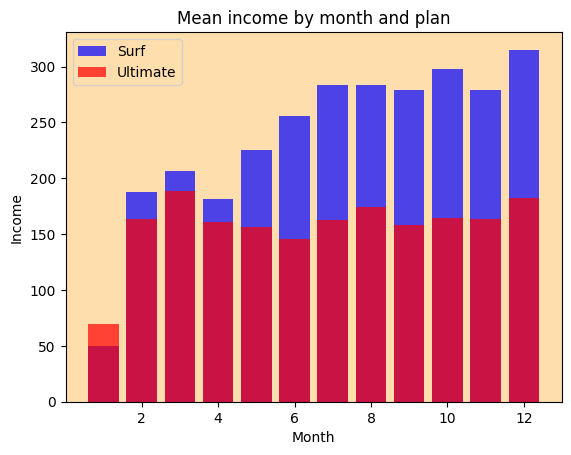

In [142]:
mean_income_plan= new_df2.groupby(['month', 'plan'])['total_paid'].mean().reset_index()

fig, ax = plt.subplots()

surf_usd1= mean_income_plan.query('plan == "surf"')
ax.bar(surf_usd1['month'], surf_usd1['total_paid'], label='Surf', alpha=0.7, color='b')

ult_usd1= mean_income_plan.query('plan == "ultimate"')
ax.bar(ult_usd1['month'], ult_usd1['total_paid'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Income')
ax.set_title('Mean income by month and plan')

ax.legend()

plt.show()

In [143]:
mean_income_plan

,month,plan,total_paid
0,1,surf,50.000000
1,1,ultimate,70.000000
2,2,surf,187.730000
3,2,ultimate,164.000000
4,3,surf,206.810870
5,3,ultimate,189.000000
6,4,surf,181.510600
7,4,ultimate,161.000000
8,5,surf,225.290519
9,5,ultimate,156.655172




<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Los valores para esta tabla no son los adecuados. El promedio del pago se encuentra entre 20 y 74. Estás sumando algún valor extra.
    
</div>


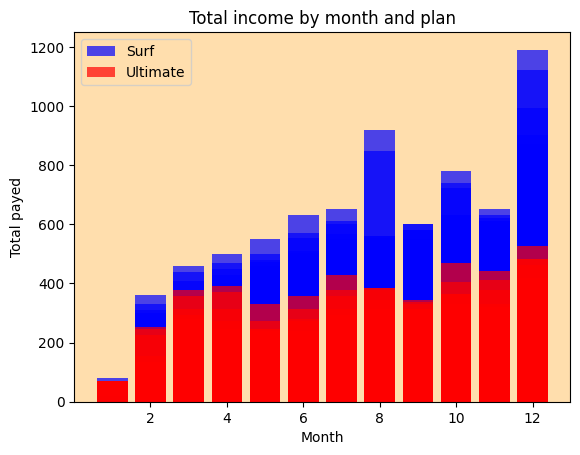

In [144]:
mon_plan_payed = new_df2[['month', 'plan', 'total_paid']]

total_income = mon_plan_payed.groupby(['plan', 'month']).sum()

fig, ax = plt.subplots()

surf_usd2= mon_plan_payed.query('plan == "surf"')
ax.bar(surf_usd2['month'], surf_usd2['total_paid'], label='Surf', alpha=0.7, color='b')

ult_usd2= mon_plan_payed.query('plan == "ultimate"')
ax.bar(ult_usd2['month'], ult_usd2['total_paid'], label='Ultimate', alpha=0.7, color='r')

ax.set_xlabel('Month')
ax.set_ylabel('Total payed')
ax.set_title('Total income by month and plan')

ax.legend()

plt.show()

In [145]:
income_mean = new_df2.groupby('month')['total_paid'].mean()
income_var = new_df2.groupby('month')['total_paid'].var()
print(income_mean)
print(income_var)

month
1      63.333333
2     177.348125
3     200.704286
4     175.444085
5     206.512925
6     219.713889
7     244.286444
8     250.441416
9     242.027393
10    256.296880
11    243.129780
12    272.533348
Name: total_paid, dtype: float64
month
1       466.666667
2     13613.364390
3     20652.489290
4     19469.087247
5     19729.671253
6     17393.331225
7     21780.260198
8     25114.629512
9     19839.873156
10    23545.488351
11    20917.438113
12    27119.453736
Name: total_paid, dtype: float64


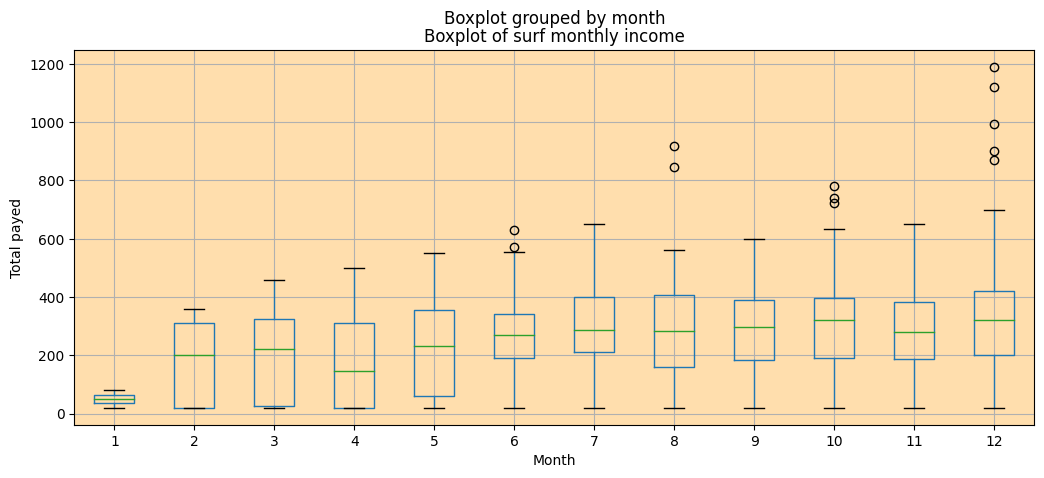

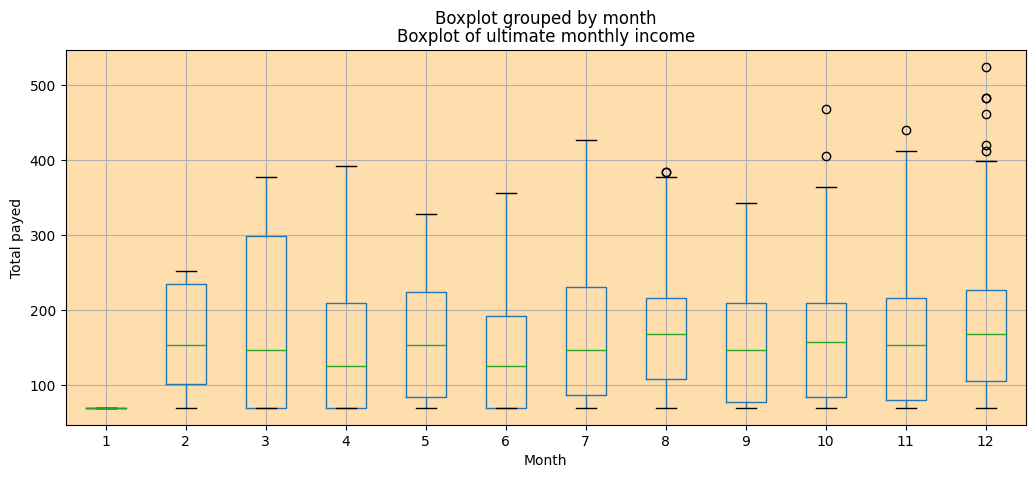

In [146]:
surf_bplot_messages = surf.boxplot(column='total_paid', by='month', figsize=(12,5))
plt.ylabel('Total payed')
plt.xlabel('Month')
plt.title('Boxplot of surf monthly income')
plt.show()
ultimate_bplot_messages = ultimate.boxplot(column='total_paid', by='month', figsize=(12,5))
plt.ylabel('Total payed')
plt.xlabel('Month')
plt.title('Boxplot of ultimate monthly income')
plt.show()

Aunque uno pueda pensar que los ingresos de el plan mas costoso pueda ser mayor, pues no. Los usuarios de plan surf tienen una media mas altas e incluso valores atipicos, es decir, usuarios que ganan mas dinero a pesar de no tener el plan mas costoso.

## Probar las hipótesis estadísticas.


Vamos a probar las siguientes hipotesis:

Hipotesis Nula: Los ingresos de los usuarios de los planes surf y ultimate son relativamente iguales.

Hipotesis Alternativa: Los ingresos de los usuarios de los planes surf y ultimate son diferentes.

Para esto vamos a usar la herramienta numpy, que es principalmente usada para la estadistica. 

Vamos a usar como valor alfa 0.05 ya que es lo que generalmente se usa. Vamos a usar la herramienta st.ttest_ind, pues nos sirve para comparar si las dos variables son relevantemente iguales en ingreso. Vamos a establecer el argumento equal_var en False, pues no creemos que las varianzas de ambas sean similares.

In [147]:
# Prueba las hipótesis
surf_income = surf[['total_paid']]

ult_income = ultimate[['total_paid']]

alpha = 0.05

results = st.ttest_ind(surf_income, ult_income, equal_var=False)

print('p-value:', results.pvalue)

if (alpha > results.pvalue):
    print('Rechazamos la hipotesis nula: Los ingresos de los usuarios surf y ultimate son relativamente iguales.')
else:
    print('No rechazamos la hipotesis nula: Los ingresos de los usuarios surf y ultimate son diferentes.')

p-value: [1.38365524e-97]
Rechazamos la hipotesis nula: Los ingresos de los usuarios surf y ultimate son relativamente iguales.



Ahora vamos a probar la hipotesis de que el ingreso promedio de los usuarios del area de NY-NJ es diferente al de los usuarios de otras regiones.

Hipotesis nula: Los ingresos promedio de los usuarios del area de NY-NJ son relativamente iguales a los de los usuarios de otras regiones.

Hipotesis alternativa: Los ingresos promedio de los usuarios del area de NY-NJ son diferentes a los de los usuarios de otras regiones.

Como ya tenemos el alpha definido no hace falta hacerlo de nuevo. Vamos a hacer un query del new_df2 donde las ciudades no sean Nueva York o Nueva Jersey, y otro donde sean solo Nueva York o Nueva Jersey. Luego les aplicaremos el mismo st.ttest_ind() con el argumento equal_var= False ya que no creemos que las varianzas sean iguales.

In [148]:
nj_ny_users = new_df2.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
nj_ny_income = nj_ny_users[['total_paid']]
nj_ny_income

other_users = new_df2.query('city !="New York-Newark-Jersey City, NY-NJ-PA MSA"')
other_users_income = other_users[['total_paid']]
other_users_income

results_2 = st.ttest_ind(nj_ny_income, other_users_income, equal_var=False)

print('p-value:', results_2.pvalue)

if alpha > results_2.pvalue:
    print('Rechazamos la hipotesis nula: Los ingresos promedio de los usuarios de NY-NJ son relativamente iguales a los de los usuarios de otras regiones.')
else:
    print('No rechazamos la hipotesis nula: Los ingresos promedio de los usuarios de NY-NJ son diferentes a los de los usuarios de otras regiones.')

p-value: [0.00438478]
Rechazamos la hipotesis nula: Los ingresos promedio de los usuarios de NY-NJ son relativamente iguales a los de los usuarios de otras regiones.


# Prueba las hipótesis


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones importantes (suposiciones) que tomaste y que te llevaron a procesar y analizar los datos del modo en que lo hiciste.]



<div class="alert alert-block alert-warning">
<b>Comentario del revisor #2</b> <a class=“tocSkip”></a>
No olvides eliminar los comentarios predefidinos en los notebooks. 
    
</div>


## Primera conclusion

Los usuarios del plan surf en general hacen un mayor uso de llamadas, mensajes, gb que los del plan ultimate a pesar de tener un menor costo que ultimate. Esto se puede comprobar a traves de los histogramas y diagramas de caja hechos en el punto que se estudia el comportamiento del usuario. El mes en el que mayor tiene uso es diciembre.

Los usuarios de surf tambien se puede ver que tienen un mayor ingreso que los de ultimate. A lo mejor son ahorradores, quien sabe.

## Segunda conclusion

Tras haber hecho el calculo, se puede ver que los ingresos de surf y ultimate no son relativamente iguales. Como se visualizo en los graficos, el de surf es mayor y ahora se puede demostrar estadisticamente con la probabilidad gracias a la herramienta numpy.

## Tercera conclusion

Se rechaza la hipotesis nula que indica que los ingresos promedio de los usuarios de NY-NJ son relativamente iguales a los de los usuarios de otras regiones. Para poder ver cual tiene mayor ingreso se puede hacer un groupby y una suma de los ingresos totales por ciudad, pero no es el fin del analisis. 

# Conclusion general

Tras haber hecho los estudios en los comportamientos de usuarios, se puede decir con seguridad que el plan en el que se deberia invertir mas presupuesto es surf, pues es el que genera mas para la empresa. Puede tambien que se quiera revisar a detalle el plan de ultimate, pues a lo mejor se puede mejorar para que hayan mas usuarios que esten interesados en este. 

A simple vista se puede decir que la empresa ha tenido buena ganancia de ambos planes, especificandonos en la de surf. Tambien viendo que el mes que genera mas ganancia es diciembre, a lo mejor por festividades!